# Product classification by product details

In [1]:
# import library
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pythainlp
import pythaispell
from gingerit.gingerit import GingerIt
from langdetect import detect
import nltk
from keras import *
from keras.utils import to_categorical
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords
from pythainlp.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.corpus import words
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from pythainlp.corpus.common import thai_words
from pythainlp.tokenize import dict_trie
from pythainlp.tag.named_entity import ThaiNameTagger
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Dataset 

- ทำการ import ข้อมูลเข้ามาจากไฟล์ Excel ใส่ใน dataframe แล้วทำการแบ่ง columns ออกเป็น feature และ label 

In [2]:
# import data from Excel
df = pd.read_excel('./All_Perfect_Data.xlsx',sheet_name=None)

In [3]:
# drop column that does not use
df0 = df['Sheet0'].drop(columns='a')
df1 = df['Sheet1'].drop(columns='a')
df2 = df['Sheet2'].drop(columns='a')
df3 = df['Sheet3'].drop(columns='a')
df4 = df['Sheet4'].drop(columns='a')
df5 = df['Sheet5'].drop(columns='a')
df6 = df['Sheet6'].drop(columns='a')
df7 = df['Sheet7'].drop(columns='a')
df8 = df['Sheet8'].drop(columns='a')
df9 = df['Sheet9'].drop(columns='a')
df10 = df['Sheet10'].drop(columns='a')
df11 = df['Sheet11'].drop(columns='a')
df_cat = df['Category']
df_cat

,id,category
0,0,อุปกรณ์ อิเล็กทรอนิกส์
1,1,อุปกรณ์เสริม อิเล็กทรอนิกส์
2,2,ทีวีและเครื่องใช้ ไฟฟ้าในบ้าน
3,3,สุขภาพและความงาม
4,4,เด็กอ่อน และของเล่น
5,5,ซูเปอร์มาร์เก็ต และสัตว์เลี้ยง
6,6,บ้านและไลฟ์สไตล์
7,7,แฟชั่นผู้หญิง
8,8,แฟชั่นผู้ชาย
9,9,เครื่องประดับ


In [211]:
df['Sheet9'].drop(columns='a')

,Category,Description
0,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ห...
1,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ห...
2,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ห...
3,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ห...
4,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ห...
...,...,...
814,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ช...
815,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ช...
816,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ช...
817,9,นาฬิกา แว่นตาและเครื่องประดับเครื่องประดับผู้ช...


In [4]:
# Concatenate data from sheets
df = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11], ignore_index=True)

In [5]:
df

,Category,Description
0,0,SmartphonesSAMSUNG Galaxy A20s *ประกันศูนย์ 1ป...
1,0,SmartphonesSamsung A30 Ram4/64GB (เครื่องศูนย์...
2,0,SmartphonesSamsung Galaxy A10 Ram2/32GB จอ 6.2...
3,0,SmartphonesSamsung Galaxy M30s (4/64GB) ( โทรศ...
4,0,SmartphonesSamsung Galaxy A10 Ram2/32GB จอ 6.2...
...,...,...
29105,11,ยานยนต์และอุปกรณ์มอเตอร์ไซค์เครื่องแต่งกายและห...
29106,11,ยานยนต์และอุปกรณ์มอเตอร์ไซค์เครื่องแต่งกายและห...
29107,11,ยานยนต์และอุปกรณ์มอเตอร์ไซค์เครื่องแต่งกายและห...
29108,11,ยานยนต์และอุปกรณ์มอเตอร์ไซค์เครื่องแต่งกายและห...


## Train/Test split

In [6]:
# Seperate data into feature(xx) and label(yy)
xx = df['Description'].values
yy = df['Category'].values

In [7]:
# name of each category
labels = df_cat['category'].values
labels.shape

(12,)

In [217]:
# Explore shape of features and labels
xx.shape,yy.shape

((29110,), (29110,))

In [8]:
# Split the data into train and test set (test size = 0.1)
xx_train, xx_test, yy_train, yy_test = train_test_split(xx,yy, test_size=0.1, random_state=47,stratify=yy)

# Split the training data for validating (validation size = 0.2)
xx_train, xx_val, yy_train, yy_val = train_test_split(xx_train,yy_train, test_size=0.2, random_state=47,stratify=yy_train)

print("train size = ",xx_train.size,'\ntest size = ',xx_test.size,'\nvalidation size = ',xx_val.size)

train size =  20959 
test size =  2911 
validation size =  5240


Text(0.5, 1.0, 'y val')

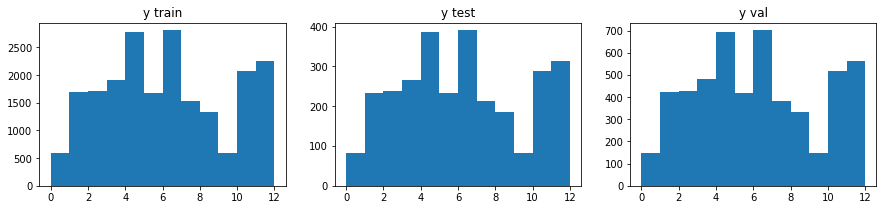

In [10]:
# Plot labels distribution
fig,ax =plt.subplots(1,3,figsize=(15,3))

bins = [0,1,2,3,4,5,6,7,8,9,10,11,12]

ax[0].hist(yy_train,bins=bins)
ax[0].set_title('y train')
ax[1].hist(yy_test,bins=bins)
ax[1].set_title('y test')
ax[2].hist(yy_val,bins=bins)
ax[2].set_title('y val')

In [220]:
# Exploring validation data
xx_val,yy_val

(array(['ยานยนต์และอุปกรณ์ยานยนต์ชิ้นส่วนและอะไหล่รถยนต์ปัดน้ำฝนและตัวชะล้างDenso ใบปัดน้ำฝน ขนาด 20" x1 ชิ้น ทนทาน ประสิทธิภาพการทำงานสูง Wiper Bladeผลิตจากยางคุณภาพดีมีความยืดหยุ่นสูงน้ำหนักเบาหมุดที่ใช้ยึดชิ้นส่วนทำจากเรซินป้องกันการเกิดสนิมแบรนด์ DensoSKU DE127OTAAMBN79ANTH-44968754ประเภทของการรับประกัน ไม่มีการประกันรุ่น 20',
        'นาฬิกา แว่นตาและเครื่องประดับนาฬิกาผู้หญิงทางการนาฬิกาอัจริยะ วัดความดัน วัดการวิ่ง เตือนการโทรเข้า ตั้งปลุก นาฬิกา Smart Barnd นาฬิกาที่ตอบโจทย์ ใส่ได้ทุกเพศ ทุกวัย รุ่น M4อัตราการเต้นของหัวใจ, ความดันโลหิต, ออกซิเจนในเลือดIP68 กันน้ำได้สวมสร้อยข้อมืออาบน้ำ, ว่ายน้ำ, ฯลฯ.สายคล้องไหล่ถอดออกได้เป็นมิตรกับสิ่งแวดล้อม TPE สำหรับสวมใส่สบายบลูทูธ 4.0, เตือนความจำ, การแจ้งเตือนทาง SMS.การตรวจสอบการนอนหลับ, การเตือนอย่างไม่หยุดนิ่ง, IP67 กันน้ำแบรนด์ UcobuySKU 270627085_TH-423514748ประเภทของการรับประกัน มีการรับประกันรุ่น SMART-M4ระยะเวลาการรับประกัน 2 สัปดาห์',
        'เด็กอ่อนและเด็กวัยหัดเดินนมผงและอาหารสำหรับเด็ก Newอาหารเด็กและทารกอาหารเสริมสำหรับเด็ก

In [221]:
# Type of the data
type(xx_train)

numpy.ndarray

## Text pre-process (clean)

In [9]:
# custom dictionary
path_custom_dict = "./custom_dict.txt"

with open(path_custom_dict, 'r',encoding="utf8") as f:
    new_words = f.read().splitlines()
    
words = set(new_words).union(thai_words())
custom_dictionary = dict_trie(words)

In [10]:
import re
import string

# word correction for EN
#parser = GingerIt()

# download stopwords of TH and EN
nltk.download('words')
th_stop = tuple(thai_stopwords())
en_stop = tuple(get_stop_words('en'))
p_stemmer = PorterStemmer()

# clean the text
def clean_msg(msg): 
    
    # ลบ text ที่อยู่ใน []
    #msg = re.sub(r'[<*●•►【】✨✈✅#?>]','', str(msg))
    #msg = re.sub(r'✅','',msg)
    # ลบ hashtag
    #msg = re.sub(r'#','',msg)
    msg = re.sub(r"[^A-Za-z0-9ก-๙.]","", str(msg))
    msg = re.sub(r"SKU\d+TH\d+","",str(msg))
    msg = re.sub(r"[A-Za-z]{18,}","",str(msg))
    # Delete punctuation
    str_punc = string.punctuation.replace(".","")
    for c in str_punc:
        msg = re.sub(r'\{}'.format(c),'',str(msg))
    
    # ลบ separator เช่น \n \t
    msg = ' '.join(msg.split())
    
    return msg

# split to words from text
def split_word(text):
    words = word_tokenize(text,engine='newmm',custom_dict=custom_dictionary,keep_whitespace=False)

    # Remove stop words TH and EN
    words = [i for i in words if not i in th_stop and not i in en_stop]
    
    # รากศัพท์
    # EN
    #words = [p_stemmer.stem(i) for i in words]
    
    # TH
    tokens_temp=[]
    for i in words:
        w_syn = wordnet.synsets(i)
        if (len(w_syn)>0) and (len(w_syn[0].lemma_names('tha'))>0) and not (w_syn[0].lemma_names('tha')[0].isdigit()):
            #print(w_syn[0].lemma_names('tha'))
            if(w_syn[0].lemma_names('tha')[0]=='แบต'):
                tokens_temp.append(w_syn[0].lemma_names('tha')[1])
            #elif(w_syn[0].lemma_names('tha')[0].isdigit()):
                #tokens_temp.append(w_syn[0].lemma_names('tha')[2])
            else:
                tokens_temp.append(w_syn[0].lemma_names('tha')[0])
        else:
            tokens_temp.append(i)
    
    words = tokens_temp
    
    # delete whitespace
    #words = [i for i in words if not ' ' in i]

    return words

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [13]:
split_word(clean_msg("test test ๑1.2.222  ,SKU 262862108_TH-405416049 ,I love me loaaaaaaaaaaaaaaaa"))

['testtest', '๑1.2.222']

In [11]:
# Clean the data
x_train = [clean_msg(text) for text in xx_train]
x_test = [clean_msg(text) for text in xx_test]
x_val = [clean_msg(text) for text in xx_val]

In [12]:
# mark word for spliting
x_train_word = ['|'.join(split_word(txt)) for txt in x_train]
x_test_word = ['|'.join(split_word(txt)) for txt in x_test]
x_val_word = ['|'.join(split_word(txt)) for txt in x_val]

In [241]:
x_train_word

['ชุด|เกือก|ผู้หญิง|เกือก|ผู้หญิง|เกือก|ส้น|แบน|เกือก|ก.ม.|ฟเฟอร์|เกือก|ก.ม.|ฟเฟอร์|แฟชั่น|พื้น|นุ่ม|ระบายลม|ได้ดี|วัสดุ|ด้านบน|หนัง|นิ่ม|วัสดุ|พื้น|ยาง|สี|ดำ|แดง|สี|เขียว|สีน้ำตาล|นิ้วตีน|นิ้วตีน|ทรงกลม|ลักษณะ|เลื่อน|ส้นสูง|2|ซม.|ความสูง|แพลตฟอร์ม|1|ซม.|แบรนด์|NoBrand|ชนิด|การรับประกัน|ไม่มี|ประกัน|ทรง|หัวแม่ตีน|Round',
 'อุปกรณ์|สัตว์เลี้ยง',
 'น.|แว่นตา|เครื่องประดับ|เครื่องประดับ|ผู้หญิง|เครื่องประดับ|แฟชั่น|เครื่องประดับ|ตัว|สแตนเลส|สตีล|ผสม|เครื่องประดับ|กาย|อัญมณี|ลิ้น|ปาก|ริมฝีปาก|คิ้ว|จมูก|แหวน|85|ชิ้น|เซ็ต|สากล|100|คุณภาพ|..|ออกแบบ|หรูหรา|เรียบง่าย|คลาสสิก|สแตนเลส|สตีล|คุณภาพ|สมบูรณ์แบบ|girly|..|ชุด|ยอดเยี่ยม|ลิ้น|ริมฝีปาก|คิ้ว|จมูก|แหว|น.|.|ของขวัญ|ดี|สำหรับ|คนรัก|ครอบครัว|เพื่อน|เพื่อน|งา|น.|.|แบรนด์|SmallYellowDuck|ชนิด|การรับประกัน|ไม่มี|ประกัน|รุ่น|SmallYellowDuck|25320',
 'ชุด|เกือก|ผู้หญิง|ชุด|หญิง|ร่ม|เสื้อกันฝน|MiAutomaticUmbrella|กันแดด|กันฝน|รับประกัน|FutureElectronics|วัสดุ|ผ้า|กันน้ำ|น.น.|เบา|ความหนาแน่น|ทนทาน|การใช้งาน|ป้องกัน|แดด|UV|ปุ่ม|โดยอัตโนมัติ|ปลอดภัย|21

In [242]:
print(x_val_word[:10],'-',yy_val[:10])

['รถ|อุปกรณ์|รถ|ชิ้น|อะไหล่|รถ|ปัด|ฝน|ตัว|ชะล้าง|Denso|ใบ|ปัด|ฝน|ขนาด|20|x|1|ชิ้น|ทนทาน|ประสิทธิภาพ|การทำงาน|WiperBlade|ทำ|ยาง|คุณภาพดี|ความยืดหยุ่น|น.น.|เบา|หมุด|ยึด|ชิ้น|ทำ|เรซิน|ป้องกัน|สนิม|แบรนด์|DensoSKUDE|127|OTAAMBN|79|ANTH|44968754|ชนิด|การรับประกัน|ไม่มี|ประกัน|รุ่น|20', 'น.|แว่นตา|เครื่องประดับ|น.|ผู้หญิง|ทางการ|น.|อัจ|ริ|ยะ|วัด|ความดัน|วัด|วิ่ง|เตือน|โทร|ปลุก|น.|SmartBarnd|น.|ตอบ|โจทย์|ใส่|เพศ|วัยรุ่น|เอ็ม|4|เรต|รำ|หัวใจ|ความดันโลหิต|ออกซิเจน|เลือด|IP|68|กันน้ำ|สวม|สร้อยข้อมือ|อาบน้ำ|ว่ายน้ำ|.|สาย|คล้อง|ไหล่|ถอด|เป็นมิตร|สิ่งแวดล้อม|TPE|สำหรับ|สวม|บลูทูธ|4.0|เตือน|ความจำ|แจ้ง|เตือน|SMS|.|เช็ค|นอน|เตือน|หยุดนิ่ง|IP|67|กันน้ำ|แบรนด์|Ucobuy|ชนิด|การรับประกัน|การรับประกัน|รุ่น|SMARTM|4|ระยะเวลา|การรับประกัน|2|วีค', 'เด็กอ่อน|เด็ก|วัย|หัด|เดิน|นมผง|อาหาร|สำหรับ|เด็ก|New|อาหาร|เด็ก|ทารก|อาหารเสริม|สำหรับ|เด็ก|GiffarineCalcine|แคลซีน|รส|สตอ|เบอ|รี่|Calcium|นม|อัด|เม็ด|เสริม|แคลเซียม|บำรุง|กระดูก|ฟัน|ส่วนสูง|สำหรับ|เด็ก|100|เม็ด|เสริมสร้าง|กระดูก|ฟัน|แข็งแรง|ป้องกัน|โรค|กระดูกพรุน|

## Tokenize word using keras

In [13]:
# define parameter for embedding layer

max_word = 5000
max_len = 150
embedding_size = 128

In [14]:
from keras.preprocessing import text
from keras.preprocessing import sequence

# Define Tokenizer
# split words with "|"
tokenizer = text.Tokenizer(num_words=max_word,split='|',filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n', lower=True) 
tokenizer.fit_on_texts(x_train_word)
tokenizer.word_index

{'การรับประกัน': 1,
 'ชนิด': 2,
 'แบรนด์': 3,
 'รุ่น': 4,
 'อุปกรณ์': 5,
 'สำหรับ': 6,
 '1': 7,
 'ไม่มี': 8,
 'สินค้า': 9,
 'ประกัน': 10,
 'ขนาด': 11,
 'ชุด': 12,
 'เด็ก': 13,
 'สี': 14,
 'รถ': 15,
 '2': 16,
 '.': 17,
 '3': 18,
 'x': 19,
 'new': 20,
 'เกือก': 21,
 'วัสดุ': 22,
 'ทำ': 23,
 'ปี': 24,
 'กีฬา': 25,
 'ตัว': 26,
 'กระเป๋า': 27,
 '4': 28,
 'ระยะเวลา': 29,
 'ผ้า': 30,
 'ผู้หญิง': 31,
 'เครื่อง': 32,
 'สาย': 33,
 'ชาย': 34,
 '5': 35,
 'ใส่': 36,
 'ซม.': 37,
 'ผิว': 38,
 'น.น.': 39,
 '100': 40,
 'นิ้ว': 41,
 'ไฟ': 42,
 '6': 43,
 'น้ำ': 44,
 'cm': 45,
 'คุณภาพ': 46,
 '฿': 47,
 'ชิ้น': 48,
 'ระบบ': 49,
 'เหมาะสำหรับ': 50,
 'ข้างนอก': 51,
 'ใช้': 52,
 'ป้องกัน': 53,
 'น.': 54,
 'ของเล่น': 55,
 'เครื่องประดับ': 56,
 'กล่อง': 57,
 'เดือน': 58,
 'ลด': 59,
 'ดี': 60,
 'ทำความสะอาด': 61,
 'กิจกรรม': 62,
 '10': 63,
 'เสริม': 64,
 'นุ่ม': 65,
 'เกรด': 66,
 'ผม': 67,
 'ขนาดเล็ก': 68,
 'ดูแล': 69,
 'อาหาร': 70,
 'ยาง': 71,
 'ออกแบบ': 72,
 'ดำ': 73,
 'เดิน': 74,
 'ค้ำ': 75,
 'ทนทาน': 76,
 'n

In [15]:
print(len(tokenizer.word_index))
vocab_size = len(tokenizer.word_index) + 1

73744


In [16]:
# Preprocess data function
def preprocess_fn(data):
    sequences = tokenizer.texts_to_sequences(data)
    padding_sequences = sequence.pad_sequences(sequences,maxlen = max_len)
    
    return padding_sequences,sequences

In [17]:
# Preprocess train and validation data
x_train_pad,x_train_seq = preprocess_fn(x_train_word)
x_test_pad,x_test_seq = preprocess_fn(x_test_word)
x_val_pad,x_val_seq = preprocess_fn(x_val_word)
print(x_train_pad.shape,x_val_pad.shape,x_test_pad.shape)

(20959, 150) (5240, 150) (2911, 150)


In [278]:
x_train_pad[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,   12,   21,   31,   12,  148,
        511, 5176,  836, 2103,  115,   22,   30,   88,   39,  113, 2266,
         76,  122,   53,  469,  809,  322, 1280,  193,    3,  900,    2,
          1,    8,   10,   22,   23,   12, 5611])

In [58]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
" ".join([index_to_word[i] for i in x_train_seq[2]])

'อุปกรณ์ไฟฟ้า ขนาดเล็ก'

In [249]:
seq_lens = [len(s) for s in x_train_seq]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 75.3
max length: 4030


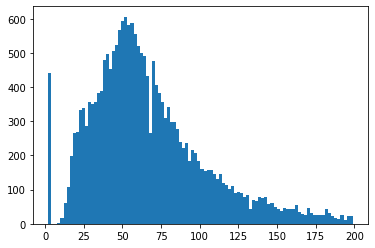

In [250]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist([l for l in seq_lens if l < 200], bins=100);

# Create model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D

In [19]:
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [20]:
# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):
    
    # Calculate result
    result = model.evaluate(features,labels,verbose=False)
    
    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))
    
    return pred_class

In [21]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

# checkpoint
filepath="./model/lstm-best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)]

In [288]:
# LSTM
lstm_output_size = 256

# Training
batch_size = 64
epochs = 10

In [289]:
# Define model
lstm = models.Sequential()
lstm.add(layers.Embedding(max_word,embedding_size,input_length=max_len))
lstm.add(Dropout(0.2))
lstm.add(layers.LSTM(lstm_output_size,dropout=0.2 ,recurrent_dropout=0.2))
lstm.add(layers.Dense(256,activation='relu'))
lstm.add(Dropout(0.5))
lstm.add(layers.Dense(12,activation='softmax'))

# Compile model
lstm.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
lstm.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, 150, 128)          1280000   
_________________________________________________________________
dropout_20 (Dropout)         (None, 150, 128)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 256)               394240    
_________________________________________________________________
dense_35 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 12)                3084      
Total params: 1,743,116
Trainable params: 1,743,116
Non-trainable params: 0
___________________________________________

In [290]:
# Fit model
his =  lstm.fit(x_train_pad,yy_train,epochs=epochs,batch_size=batch_size,validation_data=(x_val_pad,yy_val),callbacks=callbacks_list)

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20959 samples, validate on 5240 samples
Epoch 1/10
20959/20959 [==============================] - 82s 4ms/step - loss: 1.4964 - acc: 0.4390 - val_loss: 0.8122 - val_acc: 0.6714

Epoch 00001: val_acc improved from -inf to 0.67137, saving model to ./model/lstm-best.h5
Epoch 2/10
20959/20959 [==============================] - 84s 4ms/step - loss: 0.8221 - acc: 0.6971 - val_loss: 0.6044 - val_acc: 0.7815

Epoch 00002: val_acc improved from 0.67137 to 0.78149, saving model to ./model/lstm-best.h5
Epoch 3/10
20959/20959 [==============================] - 81s 4ms/step - loss: 0.4871 - acc: 0.8388 - val_loss: 0.3891 - val_acc: 0.8658

Epoch 00003: val_acc improved from 0.78149 to 0.86584, saving model to ./model/lstm-best.h5
Epoch 4/10
20959/20959 [==============================] - 81s 4ms/step - loss: 0.3453 - acc: 0.8893 - val_loss: 0.1964 - val_acc: 0.9464

Epoch 00004: val_acc improved from 0.86584 to 0.94637, saving model to ./model/lstm-best.h5
Epoch 5/10
20959/20959 [==========

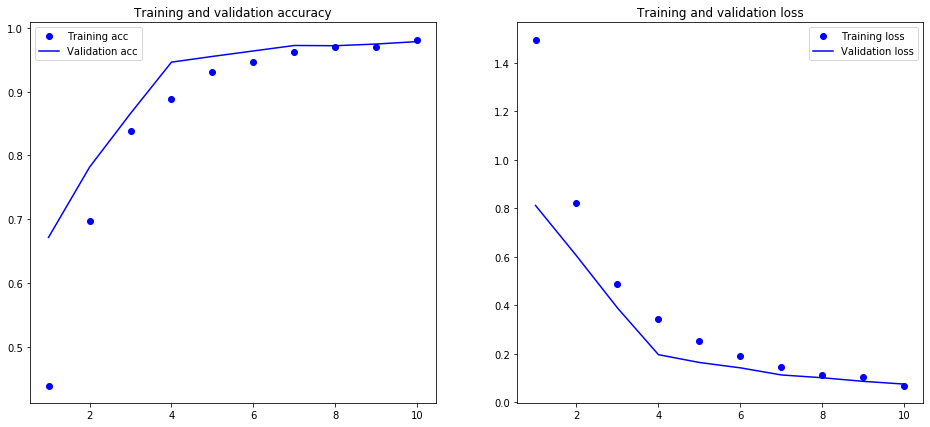

In [291]:
plot_history(his)

# Evaluate model

In [292]:
# Evaluate model
score, acc = lstm.evaluate(x_test_pad, yy_test, batch_size=batch_size)
print('Test loss:', score)
print('Test accuracy:', acc)

2911/2911 [==============================] - 4s 1ms/step
Test loss: 0.059770662000972925
Test accuracy: 0.981793224811554


In [293]:
evaluation_report(lstm,x_test_pad,yy_test)

[[ 81   0   0   0   0   0   0   1   0   0   0   1]
 [ 11 221   1   0   0   0   0   0   0   0   0   1]
 [  0   0 235   1   0   1   0   0   0   0   0   0]
 [  0   0   1 263   0   1   1   0   0   0   0   0]
 [  0   0   0   0 382   2   1   0   0   0   0   0]
 [  0   0   1   1   0 232   0   0   0   0   0   0]
 [  0   3   0   2   1   1 380   0   0   0   2   1]
 [  0   0   0   0   0   0   0 209   1   2   1   0]
 [  0   0   0   0   0   0   0   0 183   2   1   0]
 [  0   0   0   0   0   0   0   0   1  81   0   0]
 [  0   0   0   0   1   0   1   1   1   1 283   0]
 [  0   0   3   0   1   0   0   0   0   0   1 308]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93        83
           1       0.99      0.94      0.97       234
           2       0.98      0.99      0.98       237
           3       0.99      0.99      0.99       266
           4       0.99      0.99      0.99       385
           5       0.98      0.99      0.99       234
        

array([7, 8, 0, ..., 9, 3, 8], dtype=int64)

# Others model

## bidirectional-LSTM

In [304]:
# Hyperparameter
batch_size = 64
epochs = 10
embedding_size = 128
# checkpoint
filepath="./model/lstm-bidirectional.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)]

In [305]:
# Define the model
lstm2 = Sequential()
lstm2.add(Embedding(max_word, embedding_size, input_length=max_len))
lstm2.add(Dropout(0.2))
#lstm2.add(layers.SpatialDropout1D(0.1))
lstm2.add(layers.Bidirectional(LSTM(64)))
#lstm2.add(layers.LeakyReLU(alpha=0.01))
lstm2.add(layers.Dense(256,activation='relu'))
lstm2.add(Dropout(0.5))
lstm2.add(layers.Dense(12,activation='softmax'))

# Complie the model
lstm2.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
lstm2.summary()

# Fit the model
his2 = lstm2.fit(x_train_pad, yy_train,
          batch_size=batch_size,
          epochs=epochs,
               validation_data=(x_val_pad,yy_val),
                callbacks=callbacks_list)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 150, 128)          1280000   
_________________________________________________________________
dropout_26 (Dropout)         (None, 150, 128)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense_41 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 12)                3084      
Total params: 1,414,924
Trainable params: 1,414,924
Non-trainable params: 0
___________________________________________

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20959 samples, validate on 5240 samples
Epoch 1/10
20959/20959 [==============================] - 129s 6ms/step - loss: 1.1616 - acc: 0.5980 - val_loss: 0.5991 - val_acc: 0.8027

Epoch 00001: val_acc improved from -inf to 0.80267, saving model to ./model/lstm-bidirectional.h5
Epoch 2/10
20959/20959 [==============================] - 129s 6ms/step - loss: 0.3529 - acc: 0.8732 - val_loss: 0.2848 - val_acc: 0.9019

Epoch 00002: val_acc improved from 0.80267 to 0.90191, saving model to ./model/lstm-bidirectional.h5
Epoch 3/10
20959/20959 [==============================] - 128s 6ms/step - loss: 0.3422 - acc: 0.8892 - val_loss: 0.2308 - val_acc: 0.9378

Epoch 00003: val_acc improved from 0.90191 to 0.93779, saving model to ./model/lstm-bidirectional.h5
Epoch 4/10
20959/20959 [==============================] - 126s 6ms/step - loss: 0.2119 - acc: 0.9408 - val_loss: 0.1941 - val_acc: 0.9462

Epoch 00004: val_acc improved from 0.93779 to 0.94618, saving model to ./model/lstm-bidirection

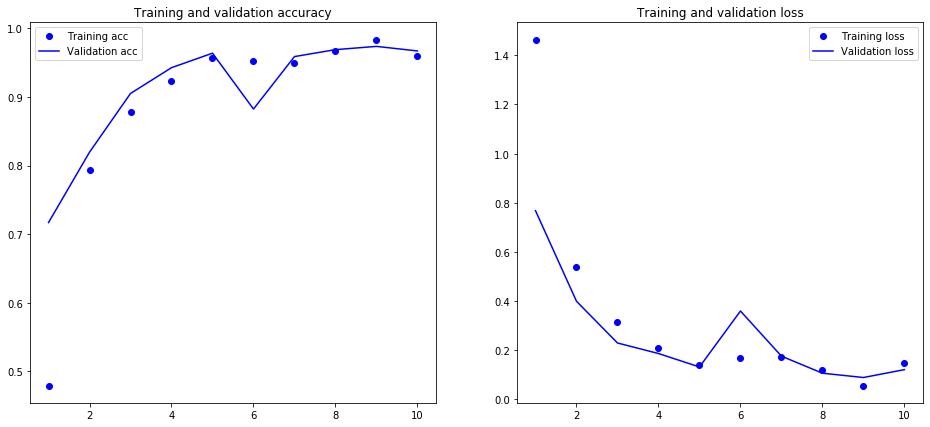

In [296]:
plot_history(his2)

In [297]:
# Evaluate model
score, acc = lstm2.evaluate(x_test_pad, yy_test, batch_size=batch_size)
print('Test loss:', score)
print('Test accuracy:', acc)

2911/2911 [==============================] - 6s 2ms/step
Test loss: 0.10661320451023816
Test accuracy: 0.964960515499115


In [298]:
evaluation_report(lstm2,x_test_pad,yy_test)

[[ 66  15   0   0   0   0   0   0   0   2   0   0]
 [  2 230   1   0   0   0   0   0   0   0   0   1]
 [  0  13 221   0   0   0   1   0   0   1   0   1]
 [  0   4   1 259   0   1   0   0   0   1   0   0]
 [  0   0   0   0 380   0   4   0   0   0   1   0]
 [  0   1   0   0   0 233   0   0   0   0   0   0]
 [  0   6   3   1   2   1 374   0   1   0   1   1]
 [  0   0   0   0   0   0   0 208   2   3   0   0]
 [  0   0   0   0   1   0   0   0 182   3   0   0]
 [  1   0   0   0   0   0   0   5   3  73   0   0]
 [  0   0   2   0   3   0   2   0   0   0 279   2]
 [  0   3   3   0   0   2   0   0   0   0   1 304]]
              precision    recall  f1-score   support

           0       0.96      0.80      0.87        83
           1       0.85      0.98      0.91       234
           2       0.96      0.93      0.94       237
           3       1.00      0.97      0.98       266
           4       0.98      0.99      0.99       385
           5       0.98      1.00      0.99       234
        

array([7, 8, 1, ..., 9, 6, 8], dtype=int64)

## GRU

In [335]:
# LSTM
gru_output_size = 256

# Training
embedding_size = 128
batch_size = 64
epochs = 10

# checkpoint
filepath="./model/gru.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint,EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001)]

In [336]:
# Define the model
lstm3 = Sequential()
lstm3.add(Embedding(max_word, embedding_size, input_length=max_len))
lstm3.add(layers.GRU(gru_output_size,dropout = 0.2, recurrent_dropout = 0.2))
lstm3.add(layers.Dense(256,activation='relu'))
lstm3.add(Dropout(0.5))
lstm3.add(layers.Dense(12,activation='softmax'))

# Complie the model
lstm3.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['acc'])
lstm3.summary()

his3 = lstm3.fit(x_train_pad, yy_train,
          batch_size=batch_size,
          epochs=epochs,
               validation_data=(x_val_pad,yy_val),
                callbacks=callbacks_list)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 150, 128)          1280000   
_________________________________________________________________
dropout_28 (Dropout)         (None, 150, 128)          0         
_________________________________________________________________
gru_10 (GRU)                 (None, 256)               295680    
_________________________________________________________________
dense_43 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_29 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 12)                3084      
Total params: 1,644,556
Trainable params: 1,644,556
Non-trainable params: 0
___________________________________________

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20959 samples, validate on 5240 samples
Epoch 1/10
20959/20959 [==============================] - 91s 4ms/step - loss: 518.0131 - acc: 0.3572 - val_loss: 1.5374 - val_acc: 0.4901

Epoch 00001: val_acc improved from -inf to 0.49008, saving model to ./model/gru.h5
Epoch 2/10
20959/20959 [==============================] - 92s 4ms/step - loss: 1.2133 - acc: 0.6071 - val_loss: 1.2772 - val_acc: 0.5788

Epoch 00002: val_acc improved from 0.49008 to 0.57882, saving model to ./model/gru.h5
Epoch 3/10
20959/20959 [==============================] - 94s 4ms/step - loss: 0.8500 - acc: 0.7159 - val_loss: 1.1707 - val_acc: 0.6189

Epoch 00003: val_acc improved from 0.57882 to 0.61889, saving model to ./model/gru.h5
Epoch 4/10
20959/20959 [==============================] - 92s 4ms/step - loss: 1.4987 - acc: 0.7685 - val_loss: 1.1281 - val_acc: 0.6351

Epoch 00004: val_acc improved from 0.61889 to 0.63511, saving model to ./model/gru.h5
Epoch 5/10
20959/20959 [==============================] 

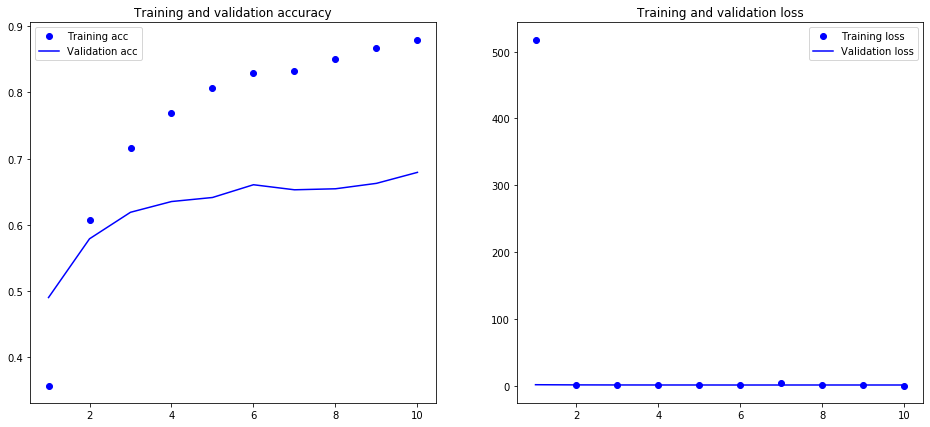

In [337]:
plot_history(his3)

In [302]:
# Evaluate model
score, acc = lstm3.evaluate(x_test_pad, yy_test, batch_size=batch_size)
print('Test loss:', score)
print('Test accuracy:', acc)

2911/2911 [==============================] - 5s 2ms/step
Test loss: 1.0917515671978042
Test accuracy: 0.653383731842041


In [303]:
evaluation_report(lstm3,x_test_pad,yy_test)

[[ 39  14  13   2   2   0   6   0   0   1   2   4]
 [  0 128  23   0  21   0  41   1   1   0   5  14]
 [  1  10 174   9   4   0  26   1   0   1   1  10]
 [  0   1   5 185  22  14  27   2   2   1   3   4]
 [  2   6   4   8 291   7  40   3   2   0  14   8]
 [  0   0   1   4   9 207   7   0   0   0   5   1]
 [  0  10  13  10  46  10 263   0   5   3  14  16]
 [  0   1   0   2   9   1  14 120  38   7  16   5]
 [  0   1   1   1  14   0  15  47  73   3  26   5]
 [  0   2   2   2  12   5   7   2   1  40   3   6]
 [  0   6   6   3  31   2  26   8   3   5 177  21]
 [  0  10  14   2  17   5  38   6   0   1  15 205]]
              precision    recall  f1-score   support

           0       0.93      0.47      0.62        83
           1       0.68      0.55      0.61       234
           2       0.68      0.73      0.71       237
           3       0.81      0.70      0.75       266
           4       0.61      0.76      0.67       385
           5       0.82      0.88      0.85       234
        

array([7, 8, 0, ..., 4, 6, 7], dtype=int64)

## CNN

In [22]:
kernel_size = 2
filters = 100
epochs = 10
batch_size = 50

In [45]:
cnn = Sequential()

cnn.add(Embedding(max_word,
                    embedding_size,
                    input_length=max_len))
cnn.add(Dropout(0.5))
cnn.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
cnn.add(layers.GlobalMaxPooling1D())
cnn.add(layers.Dense(64,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(layers.Dense(12,activation='softmax'))

# Complie the model
cnn.compile(optimizer='adadelta',loss='sparse_categorical_crossentropy',metrics=['acc'])
cnn.summary()

his4 = cnn.fit(x_train_pad, yy_train,
          batch_size=batch_size,
          epochs=epochs,
            validation_data=(x_val_pad,yy_val))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 128)          640000    
_________________________________________________________________
dropout_5 (Dropout)          (None, 150, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 149, 100)          25700     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                6464      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 12)               

C:\Users\super\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20959 samples, validate on 5240 samples
Epoch 1/10
20959/20959 [==============================] - 3s 163us/step - loss: 0.9951 - acc: 0.6890 - val_loss: 0.2232 - val_acc: 0.9328
Epoch 2/10
20959/20959 [==============================] - 3s 148us/step - loss: 0.2582 - acc: 0.9295 - val_loss: 0.1430 - val_acc: 0.9563
Epoch 3/10
20959/20959 [==============================] - 3s 148us/step - loss: 0.1857 - acc: 0.9480 - val_loss: 0.1212 - val_acc: 0.9616
Epoch 4/10
20959/20959 [==============================] - 3s 144us/step - loss: 0.1547 - acc: 0.9559 - val_loss: 0.1095 - val_acc: 0.9649
Epoch 5/10
20959/20959 [==============================] - 3s 136us/step - loss: 0.1335 - acc: 0.9597 - val_loss: 0.1010 - val_acc: 0.9670
Epoch 6/10
20959/20959 [==============================] - 3s 141us/step - loss: 0.1262 - acc: 0.9632 - val_loss: 0.0961 - val_acc: 0.9674
Epoch 7/10
20959/20959 [==============================] - 3s 145us/step - loss: 0.1143 - acc: 0.9638 - val_loss: 0.0863 - v

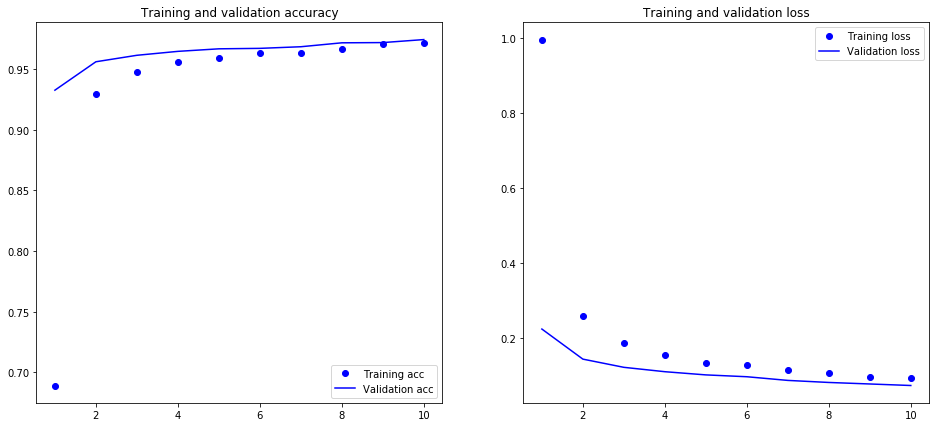

In [46]:
plot_history(his4)

In [47]:
evaluation_report(cnn,x_test_pad,yy_test)

[[ 77   3   0   0   1   0   0   0   0   0   1   1]
 [  4 225   1   2   0   0   0   0   0   0   2   0]
 [  0   3 227   2   0   0   5   0   0   0   0   0]
 [  0   0   0 261   1   1   0   1   0   0   2   0]
 [  0   0   0   0 381   0   3   0   0   0   1   0]
 [  0   2   0   2   1 226   3   0   0   0   0   0]
 [  0   2   2   1   0   1 382   0   1   0   0   1]
 [  0   0   0   0   2   0   1 208   1   1   0   0]
 [  0   0   0   1   1   0   1   4 174   2   3   0]
 [  0   0   0   0   0   0   1   0   1  80   0   0]
 [  1   1   1   0   0   1   0   1   0   0 283   0]
 [  0   1   0   0   0   0   0   0   0   0   1 311]]
              precision    recall  f1-score   support

           0       0.94      0.93      0.93        83
           1       0.95      0.96      0.96       234
           2       0.98      0.96      0.97       237
           3       0.97      0.98      0.98       266
           4       0.98      0.99      0.99       385
           5       0.99      0.97      0.98       234
        

array([7, 8, 0, ..., 9, 6, 8], dtype=int64)

## Play with model

In [261]:
# import test data from Excel
df = pd.read_excel('./test_data.xlsx',sheet_name='Sheet1')
df.head()

,Category,Details
0,6,เกรดเอเอ สินค้าดีมีคุณภาพ\nสีไม่ตก ผ้าไม่หดไม่...
1,1,9D กระจกนิรภัยสำหรับ iPhone 11 PRO MAX 6 6S 7 ...
2,1,รายละเอียดสินค้า SanDisk Ultra micro SDHC Clas...
3,1,K21 PUGB Helper 4 นิ้วเชื่อมต่อที่ถือเกม Peace...
4,0,หน้าจอ 6.4 นิ้ว ความละเอียด 3040x1440 Quad HD+...


In [262]:
test_x = df['Details'].values
test_y = df['Category'].values
test_x.shape,test_y.shape

((37,), (37,))

In [131]:
text_test = ["หน้าจอ 6.4 นิ้ว ความละเอียด 3040x1440 Quad HD+ (550 ppi)กล้องหลัง 3 ตัว (16 MP f/2.2 (Ultra Wide),12 MP f/1.5 & 2.4 (Wide), 12 MP f/2.4 (Tele))กล้องหน้า 2 ตัว (10 MP f/1.9 (Main), 8 MP f/2.2 (Live Focus)หน่วยประมวลผล Octa-core Snapdragon 855, Octa-core Exynos9 9820Ram 8/512 GBแบตเตอรี่ 4,100 mAh (Typical)"]
text_test2 = ['กล้อง Motion Eye™ หลัง19 MP +หน้า 13 MP พร้อมสุดยอดสโลว์โมชั่น ซูม8เท่า RAM 4GB+ROM 64GB เพิ่มเมมสูงสุด 256GB กันน้ำตามมาตราฐาน IP68 ถ่ายรูปโดนน้ำสบายมาก*หน้าจอ 5.2 นิ้ว TRILUMINOS™ CPU Qualcomm® Snapdragon™ 820แบตเตอรี่ 2900mAh + Sony Quick Charge']
text_test3 = ["CPU Intel Core i3-2350M @2.30 GHz หน้าจอขนาด 15.6” Full HD (1920 x 1080) HDD : 250 GB RAM: DDR3 4 GB Port : USB 2.0 x 4,VGA/ LAN port USB WiFi, DVD-ROM Battery Li-ion การ์ดจอ : Intel HD Graphics 3000 on board Battery 1-2 ชม+- #ผลิตในประเทศญี่ปุ่น คุณภาพมากกว่า 95% ฟรีเกมส์ 200 เกมส์ เล่นได้เลยไม่ต้องต่อเน็ต รับประกันสภาพสินค้าทุกชิ้น 95%+ รับประกันสินค้า 3 เดือน Condition: สินค้าหมดสัญญาเช่า รีวิวเกมส์ออนไลน์ ROV Frefire, Call of duty: https://youtu.be/qKqpGk8Ni7w"]

def test_model(text_test,label_act,model):
    clean_text_test = [clean_msg(text) for text in text_test]
    word_list_test = ['|'.join(split_word(txt)) for txt in clean_text_test]
    x_preprocess_test,x_seq_test = preprocess_fn(word_list_test)
   
    pred = model.predict(x_preprocess_test).argmax(axis=1)
    for i,x in enumerate(pred):
        print(i,x)
        print(clean_text_test[i],'\n| Predict: ',labels[int(x)],'| Actual: ',labels[int(label_act[i])])


In [365]:
test_model(test_x,test_y,lstm2)

0 8
เกรดเอเอสินค้าดีมีคุณภาพสีไม่ตกผ้าไม่หดไม่ย้วยไม่เป็นขนผ้าหนานุ่มผ้าปูหนาๆไม่ฉีกขาดง่ายใช้งานได้ยาวๆ1เซ็ตได้5ชิ้นผ้าปู1ปลอกหมอนข้าง2ปลอกหมอน2ชุดผ้าปูที่นอนลายผ้าปูจะเป็นลายเดียวกับลายผ้าห่มนะคะส่วนชุดผ้านวมจะเป็นเหมือนในรูปค่ะใช้กับเตียงสูงไม่เกิน910นิ้วชุดผ้าปูที่นอนเกรดเอเอสินค้าดีมีคุณภาพราคาถูกๆสบายๆสีไม่ตกผ้าไม่หดไม่ย้วยไม่เป็นขนผ้าหนานุ่มเบาบางผ้าปูหนาๆไม่ฉีกขาดง่ายใช้งานได้ยาวๆผ้าcottonผสมโพลีขนาด5ฟุต5ชิ้นผ้าปูที่นอน1ชิ้นปลอกหมอน2ชิ้นปลอกหมอนข้าง2ชิ้นชุดผ้าปูที่นอนลายผ้าปูจะเป็นลายเดียวกับลายผ้าห่มนะคะส่วนชุดผ้านวมจะเป็นเหมือนในรูปค่ะ 
| Predict:  แฟชั่นผู้ชาย | Actual:  บ้านและไลฟ์สไตล์
1 1
9DกระจกนิรภัยสำหรับiPhone11PROMAX66S78PLUS6plus7plus8PLUSXXRXSXSMAXปกป้องหน้าจอสำหรับAppleiPhone11678xRSMAXProPLUSฟิล์มป้องกันหน้าจอGUARDGLAS9Hคลุมทั้งหมดแก้วบางพิเศษt0.26mmความหนาของพื้นผิว9Hการเคลือบผิวของoleophobicityป้องกันน้ำมันป้องกันกรดและป้องกันด่างผลิตภัณฑ์เป็นเป็นมิตรกับสิ่งแวดล้อมและปราศจากมลพิษค่าสัมประสิทธิ์ความปลอดภัยสูงความไวสัมผัสสูงพอดีและรื้อแก้วtoughenedมีความโปร่งใสสู

In [ ]:
# Plot model
import keras
import pydotplus
from keras.utils.vis_utils import model_to_dot
keras.utils.vis_utils.pydot = pydot

plot_model(cnn, to_file='./model_cnn.png', show_shapes=True, show_layer_names=True)